In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install sb3_contrib shimmy gym stable_baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.4/178.4 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 57.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gym
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from gym import spaces
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sb3_contrib import RecurrentPPO
import matplotlib.pyplot as plt

In [ ]:
# Visit: https://suite.pycodemates.com/trading-ai-using-deep-reinforcement-learning/ for datasets and pretrained models

dataset = pd.read_csv('/content/drive/MyDrive/Trado AI/Datasets/indian_stock_2.csv')

In [ ]:
dataset = dataset[:370544]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataset

,timestamp,open,high,low,close,volume
0,2017-01-02 09:15:00+05:30,298.25,298.70,297.60,297.90,7554.0
1,2017-01-02 09:16:00+05:30,297.90,298.20,297.60,297.60,5494.0
2,2017-01-02 09:17:00+05:30,297.55,297.60,297.10,297.10,4286.0
3,2017-01-02 09:18:00+05:30,297.25,297.25,297.00,297.20,4763.0
4,2017-01-02 09:19:00+05:30,297.20,297.20,296.75,296.80,4462.0
...,...,...,...,...,...,...
370539,2021-01-01 15:24:00+05:30,1288.30,1290.55,1287.45,1290.25,15112.0
370540,2021-01-01 15:25:00+05:30,1290.25,1290.25,1288.70,1289.20,8354.0
370541,2021-01-01 15:26:00+05:30,1289.15,1290.00,1288.60,1289.05,4166.0
370542,2021-01-01 15:27:00+05:30,1289.05,1290.00,1288.60,1289.50,12556.0


In [ ]:
dataset.reset_index(drop=True, inplace=True)
keep_mask = (dataset.index + 1) % 5 == 0

dataset = dataset[keep_mask]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
dataset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,timestamp,open,high,low,close,volume
4,2017-01-02 09:19:00+05:30,297.20,297.20,296.75,296.80,4462.0
9,2017-01-02 09:24:00+05:30,296.00,296.00,295.35,295.35,3062.0
14,2017-01-02 09:29:00+05:30,294.90,295.20,294.70,295.20,856.0
19,2017-01-02 09:34:00+05:30,294.45,295.20,294.45,295.00,6735.0
24,2017-01-02 09:39:00+05:30,294.20,295.75,294.20,295.75,4418.0
...,...,...,...,...,...,...
370519,2021-01-01 15:04:00+05:30,1289.00,1289.10,1287.00,1289.00,14602.0
370524,2021-01-01 15:09:00+05:30,1288.40,1288.85,1287.25,1288.40,14865.0
370529,2021-01-01 15:14:00+05:30,1285.60,1285.95,1284.15,1285.00,26761.0
370534,2021-01-01 15:19:00+05:30,1288.50,1290.10,1288.50,1288.60,14831.0


In [ ]:
# Moving average
def calculate_ma(dataset, window):
    dataset["MA"] = dataset['Close'].rolling(window=window).mean()

# Code for calculating MACD (Moving average convergence divergence)
def calculate_macd(dataset, short_window, long_window, signal_window):
    dataset['EMA_short'] = dataset['Close'].ewm(span=short_window, adjust=False).mean()
    dataset['EMA_long'] = dataset['Close'].ewm(span=long_window, adjust=False).mean()
    dataset['MACD'] = dataset['EMA_short'] - dataset['EMA_long']
    dataset['Signal'] = dataset['MACD'].ewm(span=signal_window, adjust=False).mean()
    dataset.drop(['EMA_short', 'EMA_long'], axis=1, inplace=True)

def calculate_rsi(dataset, window):
    diff = dataset['Close'].diff()
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    dataset['RSI'] = rsi

In [ ]:
dataset.rename(columns={"close":"Close", "open":"Open", "high":"High", "low":"Low"}, inplace=True)

<ipython-input-594-24cde409e433>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.rename(columns={"close":"Close", "open":"Open", "high":"High", "low":"Low"}, inplace=True)


In [ ]:
cleaned_df = dataset.copy()

eps=0.001

cleaned_df['Open'] = np.log(cleaned_df.pop('Open')+eps)
cleaned_df['High'] = np.log(cleaned_df.pop('High')+eps)
cleaned_df['Low'] = np.log(cleaned_df.pop('Low')+eps)
cleaned_df['Close'] = np.log(cleaned_df.pop('Close')+eps)

cleaned_df = cleaned_df.drop(['timestamp', 'volume'], axis=1)

In [ ]:
cleaned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close
4,5.694409,5.694409,5.692893,5.693062
9,5.690363,5.690363,5.688164,5.688164
14,5.686640,5.687656,5.685961,5.687656
19,5.685113,5.687656,5.685113,5.686979
24,5.684263,5.689518,5.684263,5.689518
...,...,...,...,...
370519,7.161623,7.161700,7.160070,7.161623
370524,7.161157,7.161506,7.160264,7.161157
370529,7.158982,7.159254,7.157853,7.158515
370534,7.161235,7.162476,7.161235,7.161312


In [ ]:
calculate_macd(cleaned_df, 12, 26, 9)
calculate_rsi(cleaned_df, 14)
cleaned_df['MACD_Signal_diff'] = cleaned_df['MACD'] - cleaned_df['Signal']

In [ ]:
cleaned_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Open,High,Low,Close,MACD,Signal,RSI,MACD_Signal_diff
4,5.694409,5.694409,5.692893,5.693062,0.000000,0.000000,NaN,0.000000e+00
9,5.690363,5.690363,5.688164,5.688164,-0.000391,-0.000078,NaN,-3.125407e-04
14,5.686640,5.687656,5.685961,5.687656,-0.000733,-0.000209,NaN,-5.237582e-04
19,5.685113,5.687656,5.685113,5.686979,-0.001047,-0.000377,NaN,-6.700343e-04
24,5.684263,5.689518,5.684263,5.689518,-0.001078,-0.000517,NaN,-5.611180e-04
...,...,...,...,...,...,...,...,...
370519,7.161623,7.161700,7.160070,7.161623,0.000111,0.000112,51.508807,-3.240708e-07
370524,7.161157,7.161506,7.160264,7.161157,0.000093,0.000108,43.307270,-1.533127e-05
370529,7.158982,7.159254,7.157853,7.158515,-0.000134,0.000060,40.941569,-1.935508e-04
370534,7.161235,7.162476,7.161235,7.161312,-0.000087,0.000030,51.214302,-1.171134e-04


In [ ]:
cleaned_df.dropna(inplace=True)

In [ ]:
cleaned_df

,Open,High,Low,Close,MACD,Signal,RSI,MACD_Signal_diff
69,5.690701,5.691882,5.690532,5.690869,-0.000497,-0.000411,45.522658,-8.565489e-05
74,5.691545,5.692725,5.691376,5.692725,-0.000337,-0.000396,49.360296,5.888686e-05
79,5.691882,5.692051,5.687995,5.688672,-0.000532,-0.000423,50.995797,-1.086238e-04
84,5.688841,5.689180,5.687826,5.687826,-0.000746,-0.000488,50.327806,-2.580757e-04
89,5.687995,5.688334,5.687995,5.688164,-0.000878,-0.000566,52.325559,-3.121610e-04
...,...,...,...,...,...,...,...,...
370519,7.161623,7.161700,7.160070,7.161623,0.000111,0.000112,51.508807,-3.240708e-07
370524,7.161157,7.161506,7.160264,7.161157,0.000093,0.000108,43.307270,-1.533127e-05
370529,7.158982,7.159254,7.157853,7.158515,-0.000134,0.000060,40.941569,-1.935508e-04
370534,7.161235,7.162476,7.161235,7.161312,-0.000087,0.000030,51.214302,-1.171134e-04


In [ ]:
import gym
import numpy as np

class TradingEnv(gym.Env):
    def __init__(self, df, initial_balance=np.log(5000+eps), max_shares=1, transaction_cost_percentage=0.00000000000000001):
        super(TradingEnv, self).__init__()

        self.df = df # Dataset
        self.current_step = 0 # Variable for iterating through each step
        self.max_steps = len(df) - 1 # Total number of steps / lenght of the dataset

        self.initial_balance = initial_balance # Balance for the first time
        self.max_shares = max_shares # Number of shares can be bought with the price
        self.transaction_cost_percentage = transaction_cost_percentage # Cost for each transaction

        self.action_space = gym.spaces.Discrete(3)  # Actions that the agent can take. 3 actions: Buy, Sell, Hold

        # Observation space where the model can observe the data
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float32)

        self.balance = self.initial_balance # Changing balance
        self.bought = False
        self.sold = False
        self.hold = False
        self.shares_held = 0
        self.stock_price = 0
        self.total_profit = 0

    def reset(self):

        """Reset the environment each time the agent completes iteration through the dataset"""

        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_profit = 0
        self.stock_price = self.df['Close'].iloc[self.current_step]
        return self._get_observation()

    def step(self, action):

        """Method for taking action"""

        self.current_step += 1 # Iterating through the dataset features
        self.stock_price = self.df['Close'].iloc[self.current_step]
        reward = 0.0

        if action == 0:  # Buy
            self._buy_shares()



        elif action == 1:  # Sell
            self._sell_shares()
            self.action = 1


        else:
            self.hold = True
            reward = 0.001
            pass

        # Only calculate reward when the agent performs Buy and Sell action
        if (self.bought or self.sold) and self.hold == False:
            reward = self._calculate_reward()

        done = self.current_step >= self.max_steps

        observation = self._get_observation()

        return observation, reward, done, {}

    def _get_observation(self):

        """The whole observation space the agent can interact with.
        Includes prices and technical indicators"""

        observation = np.array([
            self.df['Open'].iloc[self.current_step],
            self.df['Low'].iloc[self.current_step],
            self.df['High'].iloc[self.current_step],
            self.df['Close'].iloc[self.current_step],
            self.df['MACD'].iloc[self.current_step],
            self.df['Signal'].iloc[self.current_step],
            self.df['MACD_Signal_diff'].iloc[self.current_step],
            self.df['RSI'].iloc[self.current_step],
            self.balance,
            self.shares_held,
            self.stock_price,
        ], dtype=np.float32)

        return observation

    def _buy_shares(self):

        """Environment conditions for a buy action"""

        try:

            max_shares_affordable = int(self.balance / (self.stock_price * (1 + self.transaction_cost_percentage)))
            shares_to_buy = np.random.randint(1, max_shares_affordable + 1)  # Choose a random number of shares to buy
            transaction_cost = shares_to_buy * self.stock_price * self.transaction_cost_percentage
            self.balance -= (shares_to_buy * self.stock_price) + transaction_cost
            self.shares_held += shares_to_buy
            self.bought = True
            self.sold = False
            self.hold = False
        except:
            self.bought = False
            pass

    def _sell_shares(self):

        """Environment conditions for a sell action"""

        if self.shares_held > 0:
            shares_to_sell = np.random.randint(1, self.shares_held + 1)  # Choose a random number of shares to sell
            self.balance += (shares_to_sell * self.stock_price) * (1 - self.transaction_cost_percentage)
            self.shares_held -= shares_to_sell
            self.sold = True
            self.bought = False
            self.hold = False
        else:
            self.sold = False
            pass

    def _calculate_reward(self):

        """Reward calculation based on the agent's action"""

        current_balance = self.balance + (self.shares_held * self.stock_price)
        profit = current_balance - self.initial_balance # Profit calculation based on the current balance and initial balance
        reward = (profit - self.total_profit) * 200 # Reward scaled in terms or 100
        self.total_profit = profit # updating profit
        return reward


    def render(self):
        """Information rendering to the screen"""
        print("Stock Price:", np.exp(self.stock_price) - eps)
        print("Account Balance:", np.exp(self.balance) - eps)
        print("Number of Shares:", self.shares_held)
        print("Profit:", np.exp(self.total_profit) - eps)
        print("--------------------------")

In [ ]:
env = TradingEnv(cleaned_df) # Initializing the environment

In [ ]:
observation = env.reset()

In [ ]:
# Reset the environment
done = False

def test_env(action_):
    action = action_  # Buy action
    next_observation, reward, done, info = env.step(action)
    print("Reward:",reward)
    print("Action:",action)
    #env.render()
    observation = next_observation

In [ ]:
test_env(2)
test_env(1)
test_env(2)
test_env(0)
test_env(1)

Reward: 0.001
Action: 2
Reward: 0.0
Action: 1
Reward: 0.001
Action: 2
Reward: 0.0
Action: 0
Reward: -0.30495455309598185
Action: 1


In [ ]:
env.render()

Stock Price: 294.8999999999999
Account Balance: 4992.38194402592
Number of Shares: 0
Profit: 0.9974763891099062
--------------------------


In [ ]:
model = RecurrentPPO.load('/content/drive/MyDrive/Trado AI - Deep Reinforcement Learning/Models/TradoV2.zip', env=env, ent_coef=0.70)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
#model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, ent_coef=0.60, device='cuda')
model.learn(2000000)

Streaming output truncated to the last 5000 lines.
|    value_loss           | 0.19           |
--------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.41e+04     |
|    ep_rew_mean          | 259          |
| time/                   |              |
|    fps                  | 270          |
|    iterations           | 2743         |
|    time_elapsed         | 1297         |
|    total_timesteps      | 351104       |
| train/                  |              |
|    approx_kl            | 1.149904e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 0.0444       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.42        |
|    n_updates            | 105550       |
|    policy_gradient_loss | -0.000183    |
|    value_loss           | 0.707        |

KeyboardInterrupt: ignored

In [ ]:
env = TradingEnv(cleaned_df)

observation = env.reset()

observation_arr = []
action_arr = []

for i in range(50):
    action, _ = model.predict(observation)
    obs, rewards, done, _ = env.step(action)
    observation_arr.append(obs)
    action_arr.append(action)
    print({"Rewards": rewards, "action": action})

{'Rewards': 0.0, 'action': array(0)}
{'Rewards': 0.0, 'action': array(0)}
{'Rewards': -0.9798111333950033, 'action': array(1)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.0, 'action': array(0)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.0, 'action': array(0)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.3047480323893126, 'action': array(1)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.0, 'action': array(1)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.0, 'action': array(0)}
{'Rewards': 0.0, 'action': array(0)}
{'Rewards': 0.33812235230996635, 'action': array(1)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards': 0.001, 'action': array(2)}
{'Rewards'

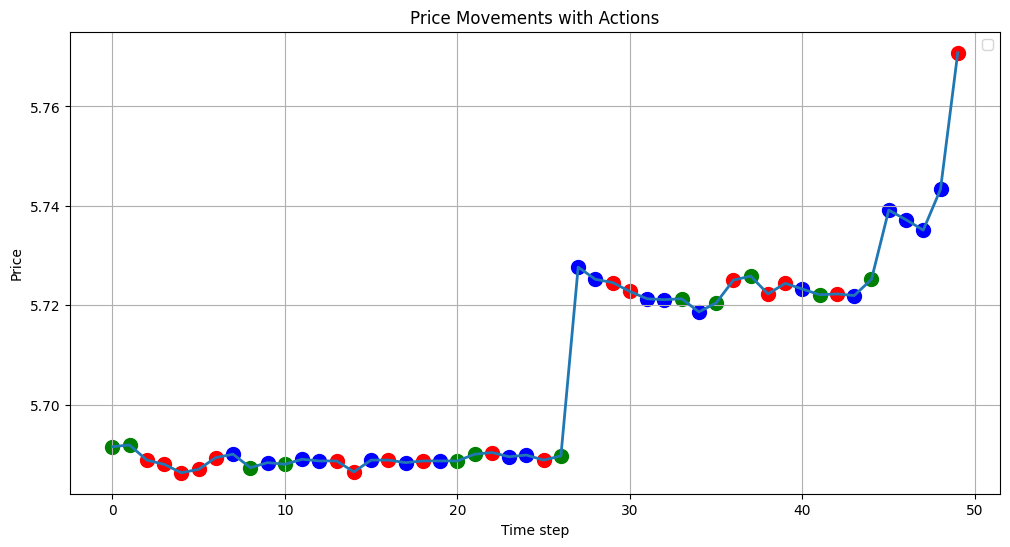

In [ ]:
# Combine observations into a single array
combined_observations = np.array(observation_arr)

# Create figure
plt.figure(figsize=(12, 6))

# Plot price movements (observation index 0)
plt.plot(combined_observations[:, 0], linewidth=2) #label='Price Movements', linewidth=2)

# Plot action dots
for t, action in enumerate(action_arr):
    if action == 0:  # Buy
        plt.scatter(t, combined_observations[t, 0], color='green', s=100)
    elif action == 1:  # Sell
        plt.scatter(t, combined_observations[t, 0], color='red', s=100)
    elif action == 2:  # Hold
        plt.scatter(t, combined_observations[t, 0], color='blue', s=100)

plt.xlabel('Time step')
plt.ylabel('Price')
plt.title('Price Movements with Actions')
plt.legend()
plt.grid()

plt.show()

In [ ]:
env.render()

Stock Price: 320.8499999999999
Account Balance: 5380.210045281541
Number of Shares: 0
Profit: 1.0750419938479097
--------------------------
